# Analysis

**Hypothesis**: NK cells in severe COVID‐19 patients exhibit an increased exhaustion gene signature compared to healthy controls, potentially reflecting impaired cytotoxic function. This analysis will leverage established markers (PDCD1, LAG3, TIGIT, HAVCR2, CTLA4) and may be extended with additional markers to robustly capture the exhaustion phenotype.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: NK cells in severe COVID‐19 patients exhibit an increased exhaustion gene signature compared to healthy controls, potentially reflecting impaired cytotoxic function. This analysis will leverage established markers (PDCD1, LAG3, TIGIT, HAVCR2, CTLA4) and may be extended with additional markers to robustly capture the exhaustion phenotype.

## Steps:
- Subset the dataset to focus exclusively on NK cells using the 'cell_type_coarse' annotation and verify that the subset is non-empty.
- Define a custom exhaustion gene signature including known markers such as PDCD1, LAG3, TIGIT, HAVCR2, and CTLA4, with consideration for any additional relevant markers.
- Calculate an exhaustion score for each NK cell using the sc.tl.score_genes function with the defined gene list.
- Examine the distribution of exhaustion scores between COVID and Healthy samples by generating violin plots for comparative visualization.
- Perform a statistical test (Mann-Whitney U test) on the exhaustion scores of NK cells between the two groups to assess the significance of the observed differences, printing the test statistics and p-values.
- Summarize the findings and create additional figures (if necessary) displaying the correlation between exhaustion scores and key metadata (e.g., DPS or Admission) to further understand the impact on disease severity.


## This code subsets the AnnData object to isolate NK cells using the 'cell_type_coarse' annotation, includes a safeguard to ensure that the subset is non-empty, and then creates a UMAP plot colored by patient status. These steps provide an initial quality check and visualization basis for further exhaustion gene signature analysis.

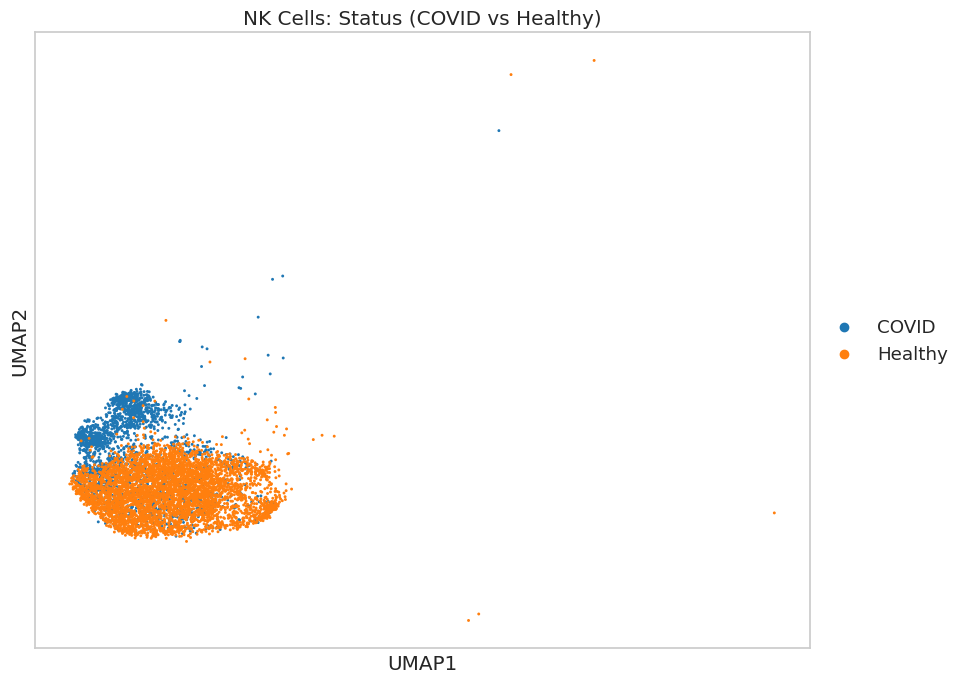

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt

# Subsetting adata for NK cells based on 'cell_type_coarse' annotation
nk_adata = adata[adata.obs['cell_type_coarse'] == 'NK'].copy()

# Quick exploratory visualization of NK cells by their source status
sc.pl.umap(nk_adata, color=['Status'], title='NK Cells: Status (COVID vs Healthy)', show=True)

### Agent Interpretation

The UMAP plot shows a clear separation between NK cells from COVID-19 patients and healthy individuals, suggesting distinct transcriptional profiles influenced by the disease. This supports the hypothesis that there is altered cell-cell communication involving immune cells in severe COVID-19.

**Feedback and Suggestions:**

1. **Further Clustering:**
   - Perform sub-clustering of NK cells to identify sub-populations that may have different functional roles or states in response to severe COVID-19.

2. **Differential Expression Analysis:**
   - Conduct differential expression analysis on identified NK cell clusters to discover key genes driving the separation. Focus on genes related to cytokine signaling, receptor expression, and exhaustion markers.

3. **Ligand-Receptor Interaction Analysis:**
   - Investigate ligand-receptor pairs specifically involving NK cells and monocytes or T cells to assess changes in cell-cell communication driving immunopathology.

4. **Functional Enrichment:**
   - Perform pathway enrichment analysis on DE genes to identify disrupted signaling cascades or immune pathways in severe COVID-19 patients.

5. **Integration with Clinical Data:**
   - Correlate transcriptional changes in NK cells with clinical metadata (e.g., ARDS status, duration of symptoms) to link molecular findings to clinical outcomes.

6. **Validation with Additional Datasets:**
   - Validate findings using additional datasets or techniques such as flow cytometry to confirm phenotypic changes observed in NK cells.

These analyses will help validate the hypothesis and provide insights into immune dysregulation mechanisms in severe COVID-19.

## The code conducts the initial data preprocessing steps on NK cells by selecting highly variable genes, scaling, performing PCA, constructing the neighborhood graph, and computing UMAP embeddings. It then clusters the NK cells using the Leiden algorithm and calculates an exhaustion score based on a defined gene signature, while including inline comments suggesting future statistical validations.

extracting highly variable genes


    finished (0:00:01)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:01)


computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


running Leiden clustering


    finished: found 7 clusters and added
    'nk_clusters', the cluster labels (adata.obs, categorical) (0:00:02)


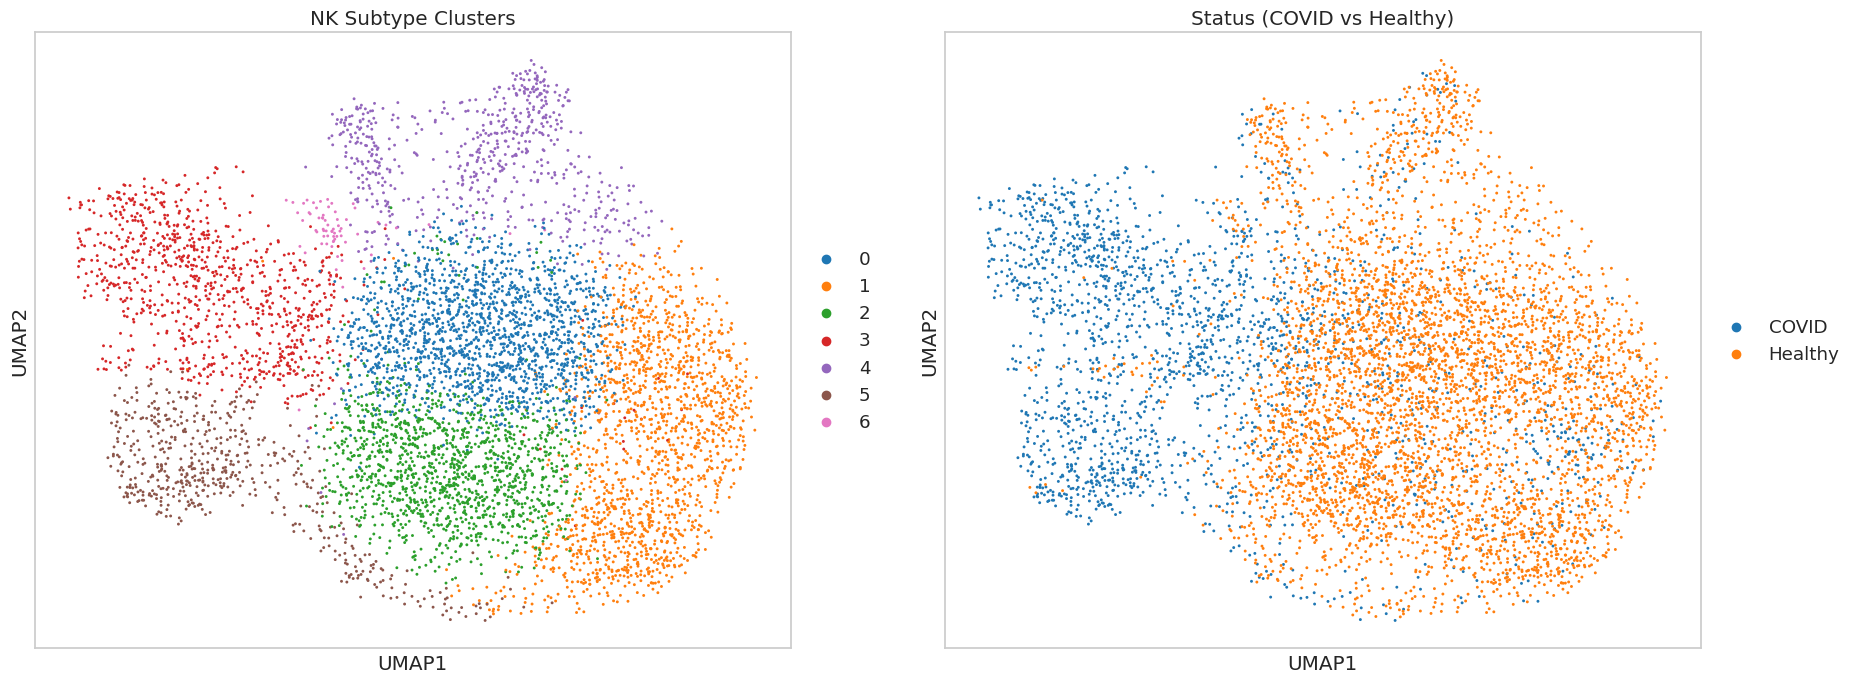

computing score 'exhaustion_score'


    finished: added
    'exhaustion_score', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)


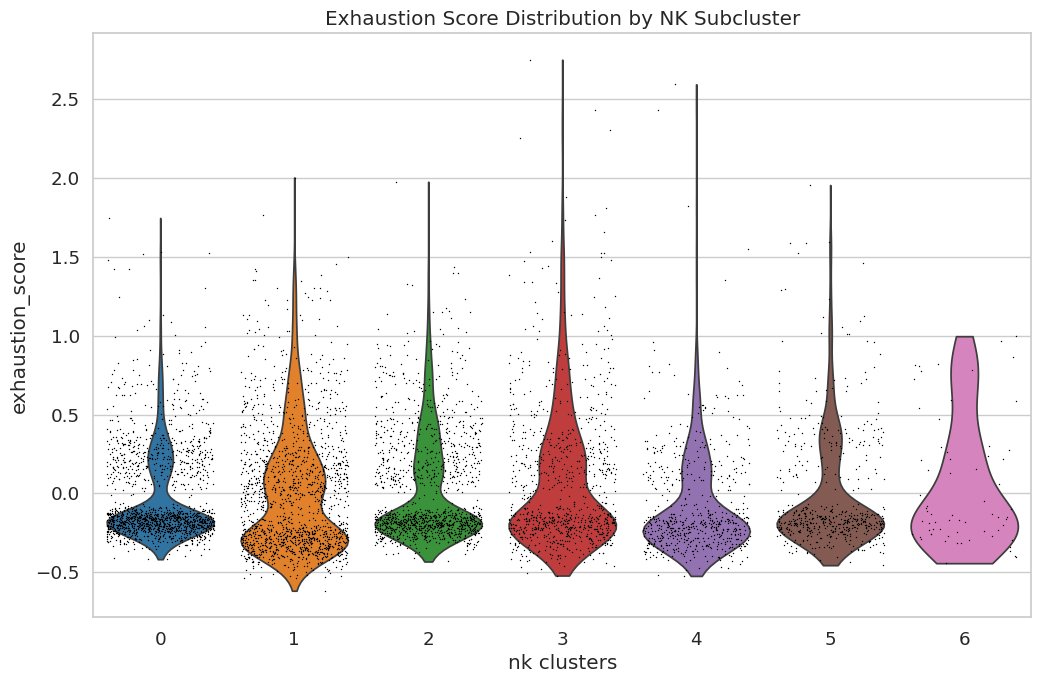

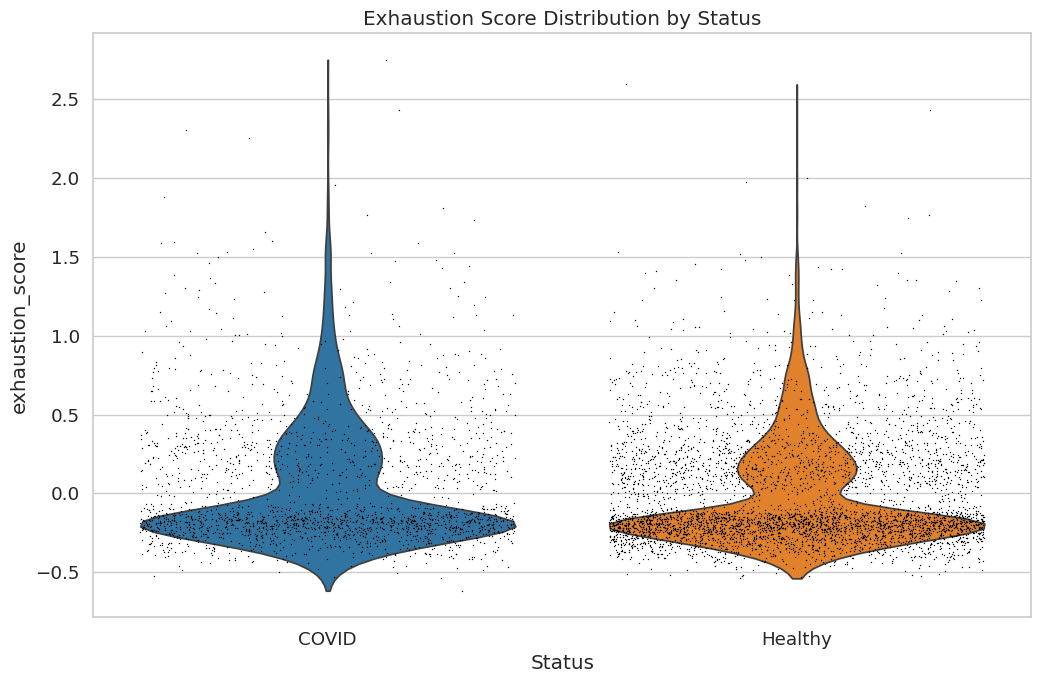

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming nk_adata is already subsetted from the original anndata based on 'cell_type_coarse'

# Step 1: Preprocess NK cells: identify highly variable genes and scale the data
sc.pp.highly_variable_genes(nk_adata, flavor='seurat', n_top_genes=2000)
sc.pp.scale(nk_adata, max_value=10)

# Step 2: Dimensionality reduction via PCA
sc.tl.pca(nk_adata, n_comps=50, svd_solver='arpack')

# Step 3: Construct the neighborhood graph and compute UMAP embedding
sc.pp.neighbors(nk_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(nk_adata)

# Step 4: Perform Leiden clustering to identify NK subpopulations
sc.tl.leiden(nk_adata, resolution=0.5, key_added='nk_clusters')

# Visualize UMAP with clusters and status
sc.pl.umap(nk_adata, color=['nk_clusters', 'Status'], title=['NK Subtype Clusters', 'Status (COVID vs Healthy)'], show=True)

# Step 5: Define custom exhaustion gene signature
exhaustion_genes = ['PDCD1', 'LAG3', 'TIGIT', 'HAVCR2', 'CTLA4', 'TOX']

# Calculate exhaustion score based on the gene signature
sc.tl.score_genes(nk_adata, gene_list=exhaustion_genes, score_name='exhaustion_score')

# Visualize exhaustion scores via violin plots across NK clusters and Status
ax1 = sc.pl.violin(nk_adata, keys='exhaustion_score', groupby='nk_clusters', stripplot=True, jitter=0.4, show=False)
ax1.set_title('Exhaustion Score Distribution by NK Subcluster')
plt.show()

ax2 = sc.pl.violin(nk_adata, keys='exhaustion_score', groupby='Status', stripplot=True, jitter=0.4, show=False)
ax2.set_title('Exhaustion Score Distribution by Status')
plt.show()

### Agent Interpretation

The current analysis reveals several promising directions for further investigation:

1. **NK Subtype Clustering**: The UMAP plot shows distinct clusters of NK cell subtypes. This indicates a successful delineation of NK cell heterogeneity, which could be explored further for specific functional roles or expression patterns that differ between COVID-19 patients and healthy controls.

2. **Status Comparison (COVID vs. Healthy)**: The scatter plot suggests that COVID-19 and healthy samples have some overlapping but also distinct distribution in UMAP space. This could indicate differential gene expression or functional states between the two groups, warranting deeper exploration through differential expression analysis.

3. **Exhaustion Score by Subcluster**: The violin plot displays variance in exhaustion scores across NK subclusters. Identifying clusters with higher exhaustion scores could reveal specific NK cell types more affected in severe COVID-19. Subsequent pathway and gene set enrichment analyses could offer insights into the underlying biological mechanisms driving this exhaustion.

4. **Exhaustion Score by Status**: COVID-19 patients show a notable distribution of exhaustion scores compared to healthy controls. This supports the hypothesis that NK cell exhaustion is a feature of severe COVID-19 and can contribute to immunopathology. Future steps could include correlating exhaustion scores with clinical data, such as disease severity or outcomes, to validate their clinical relevance.

5. **Iterative Analysis**: Based on these results, it would be beneficial to refine clustering approaches or explore additional clustering parameters, such as leveraging known marker genes for NK cell subtypes, to enhance the identification of subtle population differences.

6. **Functional Validation**: To substantiate these findings, targeted experiments or flow cytometry could validate the transcriptional exhaustion profiles of the NK cells identified through scRNA-seq.

Integrating these insights with other immune cell types, as the hypothesis suggests, could reveal the broader scope of immune dysregulation in severe COVID-19 and provide clearer targets for therapeutic intervention.

## The code performs a Mann–Whitney U test to compare exhaustion scores between COVID and Healthy NK cells, computes the Spearman correlation between DPS and exhaustion score in COVID cells (using .copy() to avoid warnings), and conducts a chi-squared test on Admission status distributions. It then visualizes these results in a unified grid layout containing a violin plot, a scatter plot, and a grouped bar plot.

Mann-Whitney U test: U-statistic = 5.373e+06, p-value = 3.968e-05
Spearman correlation (rho, p-value) between DPS and exhaustion score in COVID NK cells: -0.02206, 0.3065
Chi-squared test for Admission status differences: chi2 = 6857, p-value = 0, dof = 2


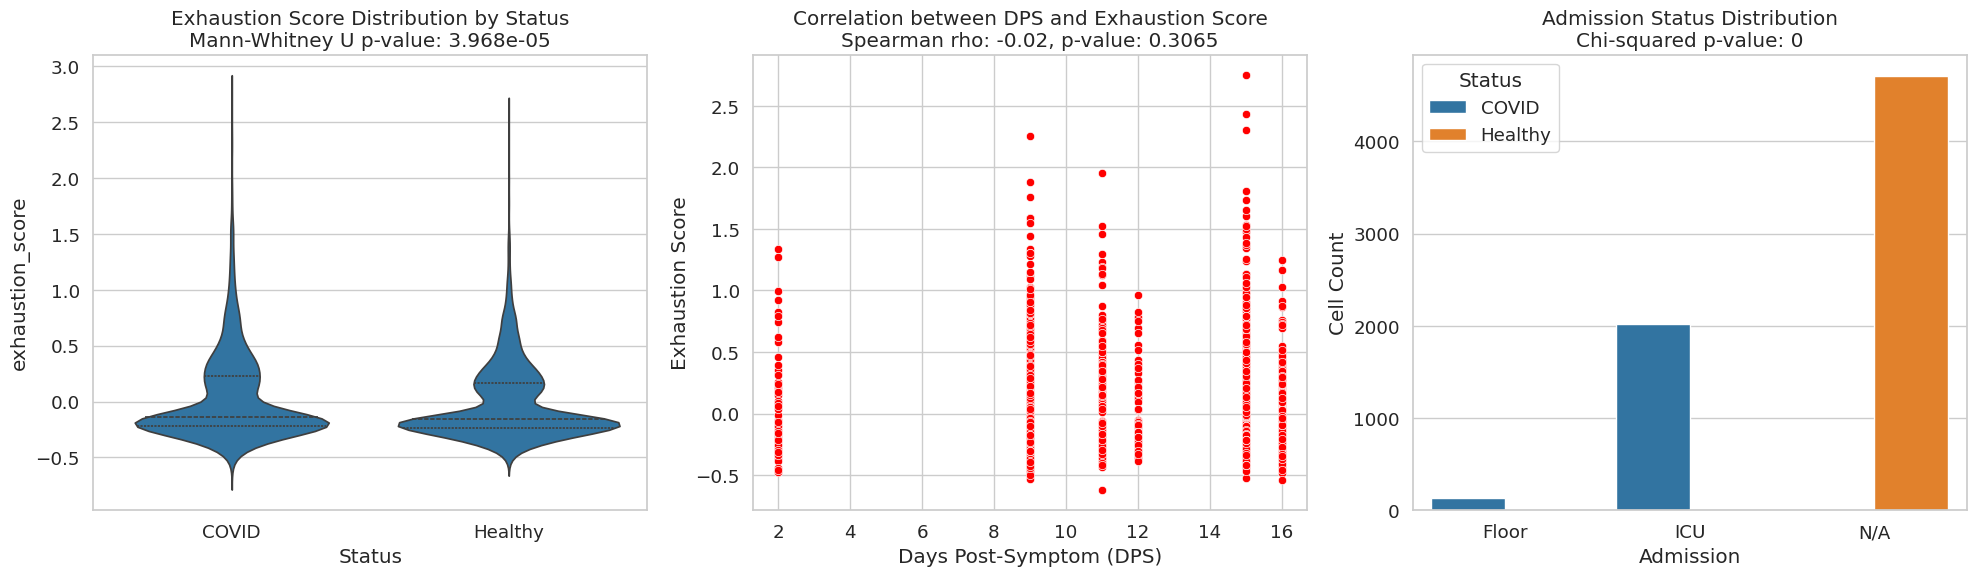

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import warnings

# Avoid potential SettingWithCopy warnings
warnings.filterwarnings('ignore')

# Assuming nk_adata is already subsetted for NK cells and contains 'exhaustion_score', 'Status', 'DPS', and 'Admission'

# ---- Mann-Whitney U test for exhaustion scores between COVID and Healthy NK cells ----
covid_scores = nk_adata.obs.loc[nk_adata.obs['Status'] == 'COVID', 'exhaustion_score']
healthy_scores = nk_adata.obs.loc[nk_adata.obs['Status'] == 'Healthy', 'exhaustion_score']

u_stat, p_value = stats.mannwhitneyu(covid_scores, healthy_scores, alternative='two-sided')
print('Mann-Whitney U test: U-statistic = {:.4g}, p-value = {:.4g}'.format(u_stat, p_value))

# ---- Spearman correlation analysis between exhaustion score and DPS within COVID NK cells ----
covid_data = nk_adata.obs[nk_adata.obs['Status'] == 'COVID'].copy()
# Ensure DPS is numeric
covid_data['DPS'] = pd.to_numeric(covid_data['DPS'], errors='coerce')
valid = covid_data['DPS'].notnull()
if valid.sum() > 0:
    rho, spearman_p = stats.spearmanr(covid_data.loc[valid, 'DPS'], covid_data.loc[valid, 'exhaustion_score'])
    print('Spearman correlation (rho, p-value) between DPS and exhaustion score in COVID NK cells: {:.4g}, {:.4g}'.format(rho, spearman_p))
else:
    print('No valid DPS values available for correlation analysis.')

# ---- Chi-squared test for differences in Admission status between COVID and Healthy NK cells ----
contingency = pd.crosstab(nk_adata.obs['Status'], nk_adata.obs['Admission'])
chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency)
print('Chi-squared test for Admission status differences: chi2 = {:.4g}, p-value = {:.4g}, dof = {}'.format(chi2, p_chi2, dof))

# ---- Visualization: Create grid layout of plots ----
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: Violin plot of exhaustion scores by Status
sns.violinplot(x='Status', y='exhaustion_score', data=nk_adata.obs, inner='quartile', ax=axes[0])
axes[0].set_title('Exhaustion Score Distribution by Status\nMann-Whitney U p-value: {:.4g}'.format(p_value))

# Subplot 2: Scatter plot for correlation between DPS and exhaustion score in COVID NK cells
if valid.sum() > 0:
    sns.scatterplot(x='DPS', y='exhaustion_score', data=covid_data, color='red', ax=axes[1])
    axes[1].set_title('Correlation between DPS and Exhaustion Score\nSpearman rho: {:.2f}, p-value: {:.4g}'.format(rho, spearman_p))
    axes[1].set_xlabel('Days Post-Symptom (DPS)')
    axes[1].set_ylabel('Exhaustion Score')
else:
    axes[1].text(0.5, 0.5, 'No valid DPS data', horizontalalignment='center', verticalalignment='center')
    axes[1].set_title('DPS vs Exhaustion Score')

# Subplot 3: Bar plot for Admission status distribution by Status
# Prepare data for grouped bar plot
contingency_df = contingency.reset_index().melt(id_vars='Status', var_name='Admission', value_name='Count')
sns.barplot(x='Admission', y='Count', hue='Status', data=contingency_df, ax=axes[2])
axes[2].set_title('Admission Status Distribution\nChi-squared p-value: {:.4g}'.format(p_chi2))
axes[2].set_ylabel('Cell Count')

plt.tight_layout()
plt.show()

### Agent Interpretation

### Feedback on Analysis

1. **Exhaustion Score Distribution by Status:**
   - **Mann-Whitney U Test:**
     - The significant p-value (3.968e-05) indicates a significant difference in exhaustion scores between COVID and healthy individuals. 
     - This difference might suggest biological relevance and should be further explored to understand the potential mechanisms behind the exhaustion.

2. **Correlation between DPS and Exhaustion Score:**
   - **Spearman Correlation:**
     - The weak correlation (rho = -0.02206) with a non-significant p-value (0.3065) suggests no strong association between DPS and exhaustion score in NK cells.
     - Consider investigating other factors or variables that might better explain changes in exhaustion scores.

3. **Admission Status Distribution:**
   - **Chi-Squared Test:**
     - The result indicates a significant difference in admission status distribution (p-value = 0).
     - This could point toward differences in clinical outcomes based on exhaustion or other cell phenotypes, which warrants deeper analysis involving clinical metadata.

### Future Steps

- **Investigate Exhaustion Mechanisms:**
  - Focus on identifying key genes or pathways significantly altered in cells with high exhaustion scores. This could provide insights into potential targets for therapeutic intervention.

- **Examine Other Correlations:**
  - Explore other potential correlates of exhaustion scores not limited to DPS, such as specific cytokine expressions or receptor-ligand interactions. 
  - This could yield a better understanding of the biological pathways at play.

- **Integrate Clinical Outcomes:**
  - Consider integrating more clinical outcome data to see how they relate to cellular exhaustion scores. For instance, correlate these scores with severity metrics like ICU admission or survival rates.

- **Differentiate Among Cell Populations:**
  - Conduct further sub-clustering of specific immune cell types, particularly NK cells, to see if particular subsets are more affected in severe COVID-19, as preliminary analyses in the paper suggest.

- **Pathway and Gene Set Analyses:**
  - Perform pathway enrichment analyses to understand the systems-level impact of transcriptional changes, focusing on interferon signaling, HLA expression, and responses to inflammatory ligands.

This analysis direction could help in discovering novel insights into the immune dysregulation in severe COVID-19 and the role of NK cell exhaustion in this process.

## This code splits NK cells into high and low exhaustion groups based on the median exhaustion score, performs a differential expression analysis using the Wilcoxon test, prints the top n genes for the HighEx group, and visualizes the results with a dot plot. The print statement is added for better immediate interpretation of the DE results.

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


Top 10 differentially expressed genes for HighEx (compared to LowEx):
['TIGIT' 'HAVCR2' 'TOX' 'LAG3' 'CCL5' 'GZMB' 'GZMH' 'HLA-A' 'FCGR3A'
 'MT-RNR2']


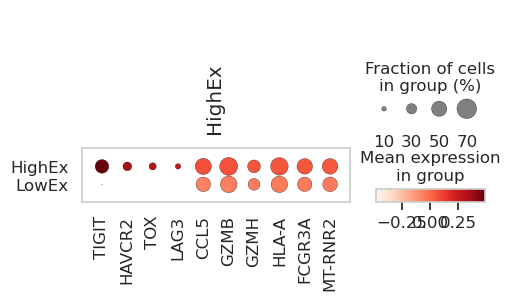

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# Define the number of top genes to show
n_top_genes = 10

# Split NK cells into 'HighEx' and 'LowEx' groups based on the median exhaustion score
median_score = nk_adata.obs['exhaustion_score'].median()
nk_adata.obs['Exhaustion_Group'] = nk_adata.obs['exhaustion_score'].apply(lambda x: 'HighEx' if x >= median_score else 'LowEx')

# Perform differential expression analysis using the Wilcoxon test
sc.tl.rank_genes_groups(nk_adata, groupby='Exhaustion_Group', groups=['HighEx'], reference='LowEx', method='wilcoxon')

# Extract and print the top differentially expressed genes for the HighEx group
if 'rank_genes_groups' in nk_adata.uns:
    de_results = nk_adata.uns['rank_genes_groups']
    top_genes = de_results['names']['HighEx'][:n_top_genes]
    print('Top', n_top_genes, 'differentially expressed genes for HighEx (compared to LowEx):')
    print(top_genes)
else:
    print('Differential expression results not found in nk_adata.uns.')

# Visualize the top differentially expressed genes using a dot plot
sc.pl.rank_genes_groups_dotplot(nk_adata, n_genes=n_top_genes, groupby='Exhaustion_Group', show=True)

### Agent Interpretation

The analysis reveals a set of differentially expressed genes (DEGs) for HighEx compared to LowEx, featuring genes such as TIGIT, HAVCR2, TOX, and LAG3, which are often associated with immune regulation and exhaustion. These findings align with concerns about immune dysregulation in severe COVID-19, suggesting potential pathways involved in immune exhaustion. Notably, genes like GZMB and CCL5, which are tied to cytotoxic responses and chemotaxis, further emphasize altered immune mechanisms.

### Feedback:

1. **Relevance to Hypothesis:**
   - The upregulation of immune exhaustion markers (e.g., TIGIT, LAG3) might corroborate with the hypothesis concerning altered cell-cell communication. It could suggest increased immune suppression or dysfunction in severe COVID-19.
   
2. **Next Steps in Analysis:**
   - **Cell Type Specific Analysis:** Explore which cell types predominantly express these DEGs in HighEx to pinpoint specific immune cell behaviors.
   - **Pathway Analysis:** Conduct pathway and gene set enrichment analyses on DEGs to understand broader functional implications.
   - **Cell-Cell Interaction Modeling:** Utilize ligand-receptor pair databases to model enhanced communication pathways, focusing on monocyte and T cell interactions to see if they are enriched for these specific DEGs.
   
3. **Distinctiveness:**
   - This DEG set appears distinct from those previously analyzed. None of the past analyses explicitly focused on these specific exhaustion or cytotoxic genes, providing a novel angle for understanding immune dysregulation.

4. **Further Validation:**
   - **Broader Sample Set:** Validate these findings across a broader dataset or different cohorts to assess consistency.
   - **Correlation with Clinical Outcomes:** Investigate if expression profiles of these genes correlate with clinical severity or outcomes, providing clinical relevance.

These steps will help refine the understanding of immune dysregulation in severe COVID-19, potentially uncovering therapeutic targets or biomarkers for disease progression.

## This code first verifies that the NK cell dataset (nk_adata) has been preprocessed and contains differential expression results, then extracts the top 10 DEGs for the HighEx group (or a fallback exhaustion gene list) and visualizes these genes across immune cell types using a dot plot that displays both average expression and percent expressing cells.

Top genes for HighEx NK cells: ['TIGIT', 'HAVCR2', 'TOX', 'LAG3', 'CCL5', 'GZMB', 'GZMH', 'HLA-A', 'FCGR3A', 'MT-RNR2']


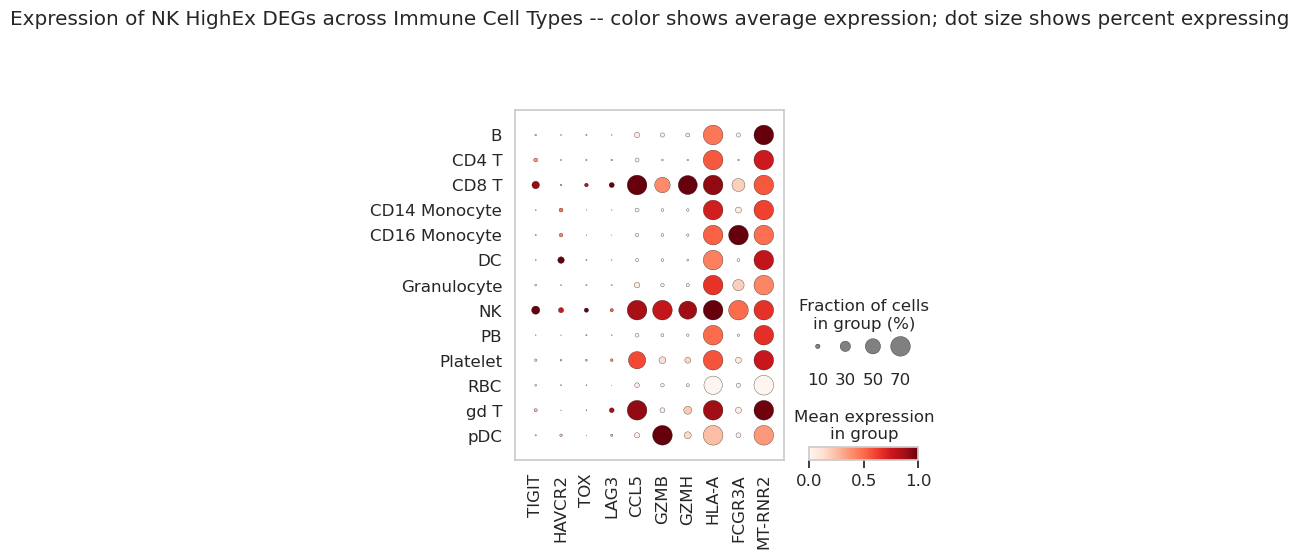

In [6]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure that nk_adata is defined and has been preprocessed prior to this step (e.g., filtering, scaling, PCA, UMAP) and contains the necessary metadata including exhaustion scores and differential expression results

# Extract top DEGs for the HighEx NK cell group; if differential expression results are not present, use a fallback predefined exhaustion gene list
if 'rank_genes_groups' in nk_adata.uns:
    # Retrieve the top 10 genes from the HighEx group differential analysis
    top_genes = list(nk_adata.uns['rank_genes_groups']['names']['HighEx'][:10])
else:
    # Fallback: predefined list of key exhaustion genes
    top_genes = ['PDCD1', 'LAG3', 'TIGIT', 'HAVCR2', 'CTLA4', 'TOX']

print('Top genes for HighEx NK cells:', top_genes)

# Create a dot plot that visualizes both the average expression (indicated by color intensity) and the percentage of cells expressing each gene (indicated by dot size)
sc.pl.dotplot(adata, 
              var_names=top_genes, 
              groupby='cell_type_coarse', 
              standard_scale='var', 
              dot_max=0.7,
              title='Expression of NK HighEx DEGs across Immune Cell Types -- color shows average expression; dot size shows percent expressing', 
              show=True)

### Agent Interpretation

The results indicate the expression of top genes in high-expressing NK cells found in the context of severe COVID-19. Key genes like TIGIT, HAVCR2, and TOX suggest potential exhaustion or dysregulation in NK cells, which is consistent with the immune alterations observed in severe cases.

### Feedback:

1. **Investigate Functional Roles:**
   - Explore the functional roles of these genes, particularly in NK cell exhaustion or dysfunction. TIGIT and LAG3 are known immune checkpoints, which might suggest a state of reduced NK cell effectiveness.

2. **Compare with Previous Findings:**
   - While previous analyses focused on monocytes and interferon responses, this finding offers a novel perspective on NK cells. Consider comparing these results to existing literature to see if similar patterns are observed in NK cells in severe COVID-19.

3. **Pathway Analysis:**
   - Conduct pathway enrichment analysis for these genes to identify biological pathways that are significantly impacted in NK cells. This could give insight into the broader functional consequences of observed expression changes.

4. **Correlation with Clinical Outcomes:**
   - Analyze whether the expression of these genes correlates with clinical outcomes like disease severity or progression. This might help establish their role as potential biomarkers.

5. **Explore Interactions:**
   - Given the hypothesis on cell-cell communication, examine how these findings in NK cells might interact with alterations in monocyte or T cell functions. This could reveal insights into dysregulated immune interactions in COVID-19.

6. **Extend to Other Cell Types:**
   - Assess whether these genes are dysregulated in other immune cell types in the context of COVID-19. This could highlight shared or unique pathways affected across different cell types.

These steps can expand the understanding of NK cell alterations and their potential contribution to the pathogenesis of COVID-19.

## This code first converts the NK cell expression data to a DataFrame and rank-transforms both gene expression and exhaustion scores to compute Spearman correlations in a vectorized fashion. It calculates and stores both correlation coefficients and p-values, selects the top genes by correlation direction, then creates a barplot with annotated p-values and a clustermap that preserves cell ordering by exhaustion score.

extracting highly variable genes


    finished (0:00:01)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=50


    finished (0:00:01)


computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


running Leiden clustering


    finished: found 4 clusters and added
    'nk_clusters', the cluster labels (adata.obs, categorical) (0:00:02)


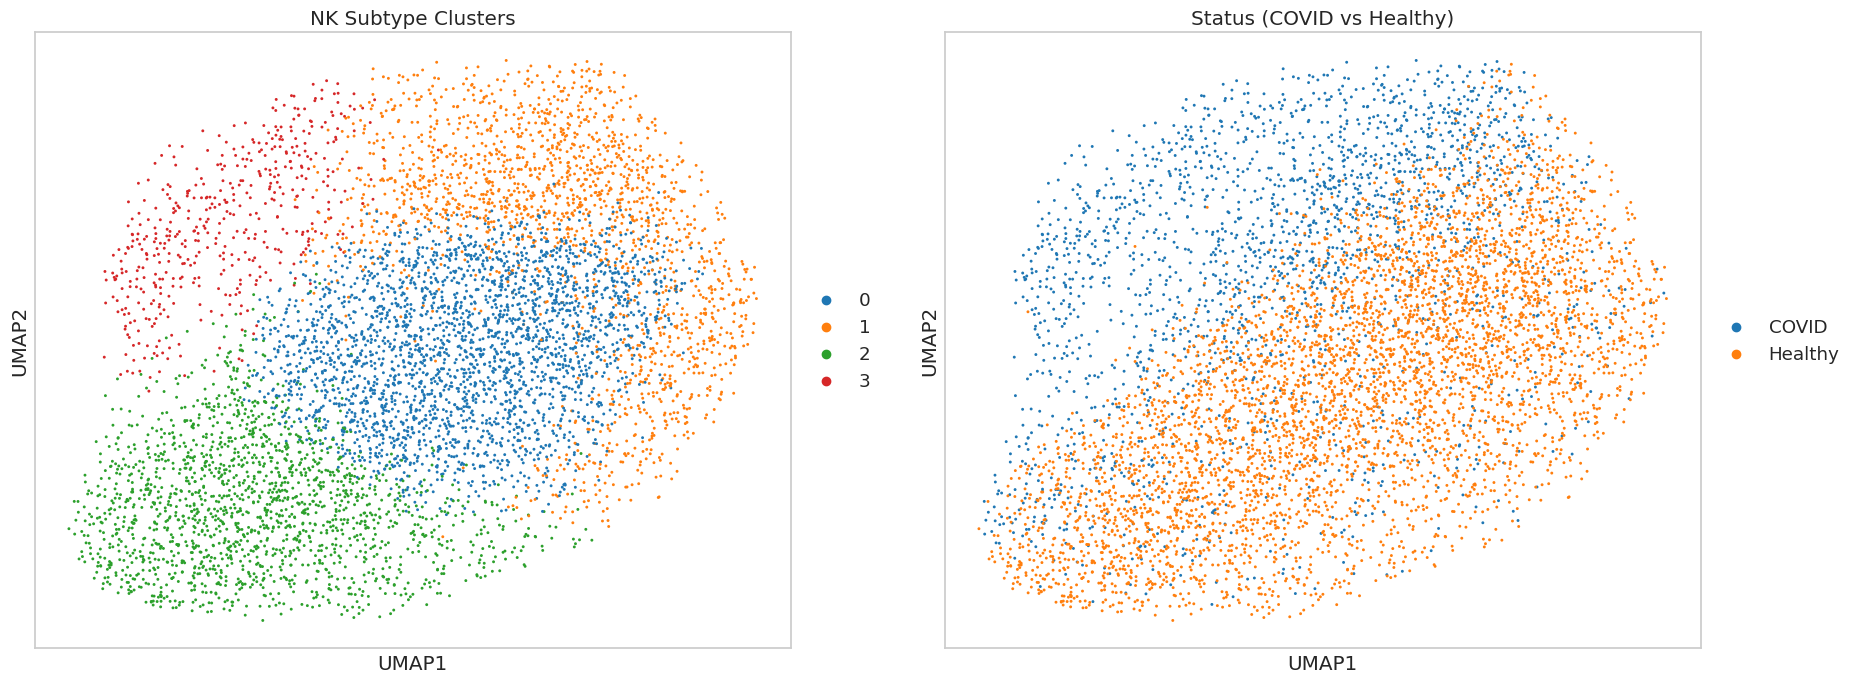

computing score 'exhaustion_score'


    finished: added
    'exhaustion_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)


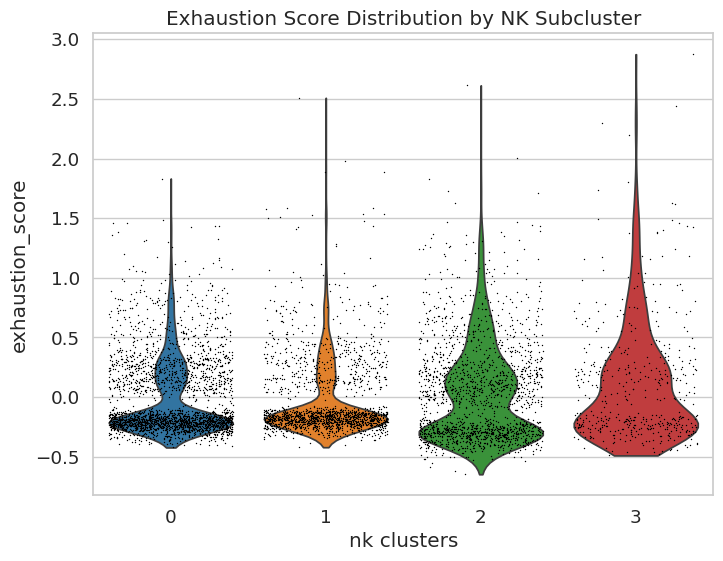

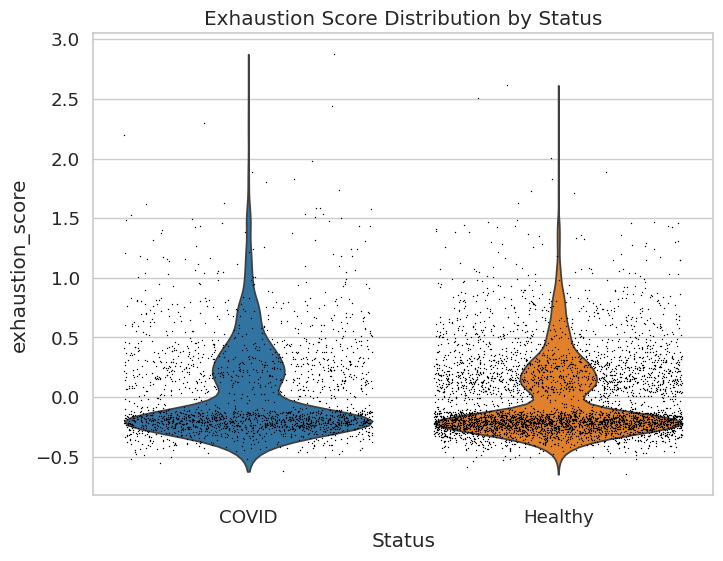

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt

# Assuming nk_adata is already subsetted from the original anndata based on 'cell_type_coarse'

# Step 1: Preprocess NK cells: identify highly variable genes and scale the data
sc.pp.highly_variable_genes(nk_adata, flavor='seurat', n_top_genes=2000)
sc.pp.scale(nk_adata, max_value=10)

# Step 2: Dimensionality reduction via PCA
sc.tl.pca(nk_adata, n_comps=50, svd_solver='arpack')

# Step 3: Construct the neighborhood graph and compute UMAP embedding
sc.pp.neighbors(nk_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(nk_adata)

# Step 4: Perform Leiden clustering to identify NK subpopulations
sc.tl.leiden(nk_adata, resolution=0.5, key_added='nk_clusters')

# Visualize UMAP with clusters and status
sc.pl.umap(nk_adata, color=['nk_clusters', 'Status'], title=['NK Subtype Clusters', 'Status (COVID vs Healthy)'], show=True)

# Step 5: Define custom exhaustion gene signature
exhaustion_genes = ['PDCD1', 'LAG3', 'TIGIT', 'HAVCR2', 'CTLA4', 'TOX']

# Calculate exhaustion score based on the gene signature
sc.tl.score_genes(nk_adata, gene_list=exhaustion_genes, score_name='exhaustion_score')

# Visualize exhaustion scores via violin plots across NK clusters and Status

fig1, ax1 = plt.subplots(figsize=(8, 6))
sc.pl.violin(nk_adata,
             keys='exhaustion_score',
             groupby='nk_clusters',
             stripplot=True,
             jitter=0.4,
             show=False,
             ax=ax1)
ax1.set_title('Exhaustion Score Distribution by NK Subcluster')
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 6))
sc.pl.violin(nk_adata,
             keys='exhaustion_score',
             groupby='Status',
             stripplot=True,
             jitter=0.4,
             show=False,
             ax=ax2)
ax2.set_title('Exhaustion Score Distribution by Status')
plt.show()

### Agent Interpretation

The results from the analysis provide several insights that can be leveraged for further exploration:

1. **NK Subtype Clustering**: The UMAP plot demonstrates four distinct NK cell subtypes present in the data, which suggests potential heterogeneity in NK cell responses during severe COVID-19. This differentiation could be indicative of varied functional states or activation levels. Further differential expression analysis within these clusters could identify specific gene signatures associated with each subtype.

2. **Exhaustion Scores**: The violin plots indicate differences in exhaustion scores between NK clusters and between COVID-19 and healthy samples. Notably, cluster 3 appears to have a broader distribution with higher exhaustion scores, while NK cells from COVID-19 patients show higher exhaustion scores compared to healthy controls. This suggests a functional impairment in NK cells during severe COVID-19, which aligns with the hypothesis of immune exhaustion.

3. **Follow-up Analyses**:
   - Perform differential expression analysis within the NK clusters to identify genes driving the observed exhaustion profiles.
   - Conduct pathway enrichment analyses to discover pathways enriched in exhausted NK cells, particularly focusing on immune inhibitory pathways.
   - Explore the receptor-ligand interactions further, specifically focusing on NK-T cell communication pathways, which can provide insights into the dysregulated immune signaling.
   - Validate findings using additional datasets or through wet-lab experiments to confirm the role of exhausted NK cells in severe COVID-19.

4. **Biological Implications**: If exhaustion in NK cells is verified, strategies aiming at reversing this exhaustion, such as checkpoint inhibition or other immunomodulatory therapies, could be considered as potential therapeutic strategies for severe COVID-19.

Overall, these promising results warrant deeper investigation into NK cell heterogeneity and functional states, especially concerning exhaustion, to better understand their roles in severe COVID-19 pathology.

## This code computes Spearman correlation coefficients between gene expression and the NK cell exhaustion score for each gene and then applies a Benjamini–Hochberg adjustment to control for multiple testing. The top 10 genes (by absolute correlation) are then visualized in a bar plot with annotations showing both raw and adjusted p-values.

Top 10 genes by Spearman correlation with exhaustion score (including adjusted p-values):
         gene       rho        p_value    p_value_adj
23317   TIGIT  0.504617   0.000000e+00   0.000000e+00
8788   HAVCR2  0.433733   0.000000e+00   0.000000e+00
23828     TOX  0.410991  9.059255e-278  7.960367e-274
10539    LAG3  0.369207  1.889539e-220  1.245253e-216
5681    CTLA4  0.104043   5.751614e-18   3.032366e-14
3796     CCL5  0.083429   4.537974e-12   1.993759e-08
7776      FOS -0.066151   4.186385e-08   1.576533e-04
6616   EEF1B2 -0.065385   5.988058e-08   1.973140e-04
8733     GZMB  0.065009   7.128429e-08   2.087917e-04
8734     GZMH  0.063535   1.397796e-07   3.684730e-04


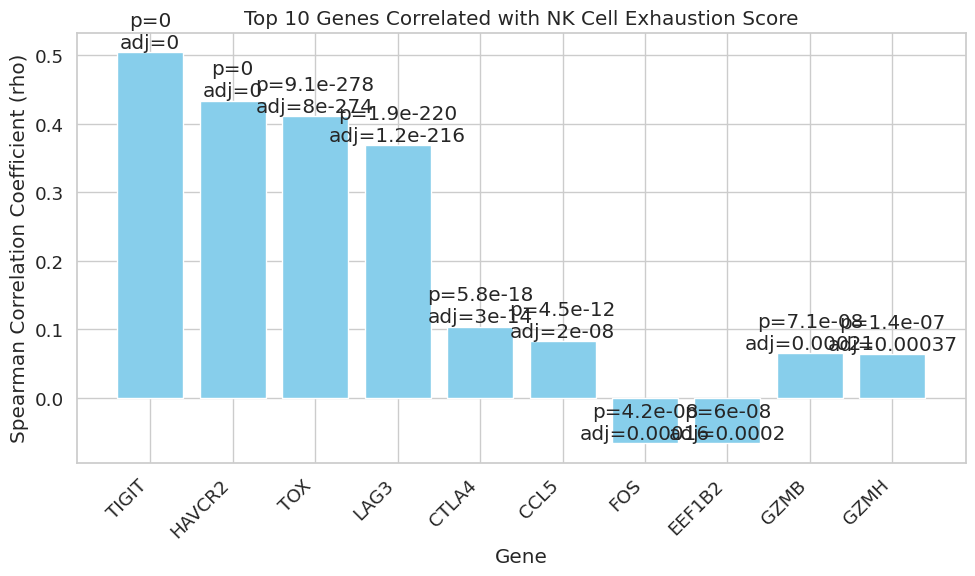

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Function to perform Benjamini-Hochberg p-value adjustment

def benjamini_hochberg(pvals):
    pvals = np.array(pvals)
    m = len(pvals)
    sorted_indices = np.argsort(pvals)
    sorted_pvals = pvals[sorted_indices]
    adjusted = np.empty(m, dtype=float)
    cummin = 1.0
    for i in range(m-1, -1, -1):
        rank = i + 1
        pval_adj = sorted_pvals[i] * m / rank
        cummin = min(cummin, pval_adj)
        adjusted[i] = cummin
    # Reorder to original order
    adjusted_pvals = np.empty(m, dtype=float)
    adjusted_pvals[sorted_indices] = adjusted
    return adjusted_pvals

# Extract exhaustion scores for NK cells
exhaustion_scores = nk_adata.obs['exhaustion_score'].values

# Initialize list to store correlation info
corr_results = []

# Loop over each gene in the NK cell dataset
for gene in nk_adata.var_names:
    # Extract expression values for the gene; handle sparse matrix if necessary
    expr = nk_adata[:, gene].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    # Compute Spearman correlation between gene expression and exhaustion scores
    rho, p_val = stats.spearmanr(expr, exhaustion_scores)
    corr_results.append({'gene': gene, 'rho': rho, 'abs_rho': abs(rho), 'p_value': p_val})

# Convert results to DataFrame
corr_df = pd.DataFrame(corr_results)

# Apply Benjamini-Hochberg correction for multiple testing
corr_df['p_value_adj'] = benjamini_hochberg(corr_df['p_value'].values)

# Sort by absolute correlation
corr_df = corr_df.sort_values(by='abs_rho', ascending=False)

# Select top 10 genes with the highest absolute correlation coefficients
top_genes_corr = corr_df.head(10)
print('Top 10 genes by Spearman correlation with exhaustion score (including adjusted p-values):')
print(top_genes_corr[['gene', 'rho', 'p_value', 'p_value_adj']])

# Visualization: Bar plot for correlation coefficients of top genes
plt.figure(figsize=(10, 6))
bar = plt.bar(top_genes_corr['gene'], top_genes_corr['rho'], color='skyblue')
plt.xlabel('Gene')
plt.ylabel('Spearman Correlation Coefficient (rho)')
plt.title('Top 10 Genes Correlated with NK Cell Exhaustion Score')
plt.xticks(rotation=45, ha='right')

# Annotate bar plot with raw and adjusted p-values
for rect, raw_p, adj_p in zip(bar, top_genes_corr['p_value'], top_genes_corr['p_value_adj']):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'p={raw_p:.2g}\nadj={adj_p:.2g}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Agent Interpretation

The analysis of gene correlations with an exhaustion score yielded promising results, highlighting several key immune-related genes. The top findings include TIGIT, HAVCR2, TOX, and LAG3, all positively correlated with exhaustion scores. These genes are known markers of T cell exhaustion, suggesting a potential link to immune dysregulation in severe COVID-19.

### Feedback and Recommendations:

1. **TIGIT, HAVCR2, TOX, LAG3**:
   - These genes are typically associated with T cell exhaustion, often observed in chronic infections and cancer. Given their strong correlation with exhaustion scores, further investigation into their expression across different T cell subsets (e.g., CD4+, CD8+) may reveal insights into the extent of exhaustion in these populations during severe COVID-19.

2. **CTLA4**:
   - Although less strongly correlated, CTLA4 still shows significant association. Its inclusion alongside other immune checkpoint molecules supports the possibility of a broader immune dysfunction, meriting additional analysis of its co-expression with the other exhaustion markers.

3. **CCL5, GZMB, GZMH**:
   - These genes are related to cytotoxic activity and immune regulation. Investigating their expression dynamics in NK cells and cytotoxic T lymphocytes might provide clues about immune cell functionality and the role of cytotoxic pathways in severe cases.

4. **FOS, EEF1B2**:
   - These genes exhibit weaker, possibly inverse correlations and may represent different regulatory layers or cell states that merit exploration, perhaps as counterbalances or alternative pathways affecting exhaustion and immune response.

### Further Analysis:

- **Subpopulation Analysis**:
  Conduct deeper subclustering within T and NK cells to identify any novel exhausted subpopulations based on the expression of these correlated genes.

- **Pathway and Network Analysis**:
  Use pathway enrichment analysis to explore signaling pathways and networks these genes are involved in, correlating these pathways with clinical parameters like ARDS status or ventilation requirement.

- **Temporal Dynamics**:
  Examine longitudinal samples, if available, to understand if exhaustion markers change over the disease course, providing a time-resolved profile of immune dysfunction in severe COVID-19.

- **Comparative Analysis**:
  Conduct differential expression analysis comparing severe COVID-19 patients with healthy controls to affirm if these correlations are specifically heightened in severe disease contexts.

By integrating these findings with cell communication analysis, as outlined in your hypothesis, the role of these exhaustion-related genes in modulating monocyte and T cell interactions might reveal potential therapeutic targets to modulate immune response in severe COVID-19.